In [1]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

Using TensorFlow backend.


In [2]:
import csv
from PIL import Image
import numpy as np
import os

In [3]:

lines = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

In [4]:
len(lines)

8037

In [5]:
with open('data/driving_log_track1_right.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

In [6]:
len(lines)

9920

In [7]:
with open('data/driving_log_track1_wrong.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

In [8]:
len(lines)

12452

In [9]:
length = len(lines)
#length = 100

lines=lines[1:length+1]

In [10]:
len(lines)

12451

Epoch 1/10
59760/59760 [==============================] - 465s - loss: 0.0329 - val_loss: 0.0224
Epoch 2/10
59760/59760 [==============================] - 293s - loss: 0.0215 - val_loss: 0.0207
Epoch 3/10
59760/59760 [==============================] - 293s - loss: 0.0198 - val_loss: 0.0198
Epoch 4/10
59760/59760 [==============================] - 293s - loss: 0.0192 - val_loss: 0.0190
Epoch 5/10
59760/59760 [==============================] - 292s - loss: 0.0187 - val_loss: 0.0182
Epoch 6/10
59760/59760 [==============================] - 292s - loss: 0.0182 - val_loss: 0.0180
Epoch 7/10
59760/59760 [==============================] - 292s - loss: 0.0177 - val_loss: 0.0175
Epoch 8/10
59760/59760 [==============================] - 293s - loss: 0.0174 - val_loss: 0.0178
Epoch 9/10
59760/59760 [==============================] - 293s - loss: 0.0172 - val_loss: 0.0170
Epoch 10/10
59760/59760 [==============================] - 293s - loss: 0.0168 - val_loss: 0.0167
dict_keys(['loss', 'val_loss'

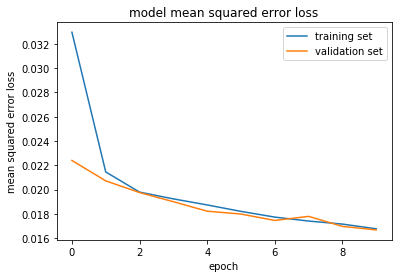

In [11]:
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(lines, test_size=0.2)


import sklearn

def generator(lines, batch_size=32):
    num_samples = len(lines)
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = lines[offset:offset+batch_size]
            
            images = []
            measurements = []
            correction = 0.2
            for line in batch_samples:
                source_path_center = line[0].split('/')[-1]
                source_path_left = line[1].split('/')[-1]
                source_path_right = line[2].split('/')[-1]

                path_center = 'data/IMG/' + source_path_center
                path_left = 'data/IMG/' + source_path_left
                path_right = 'data/IMG/' + source_path_right

                image_center = Image.open(path_center)
                image_left = Image.open(path_left)
                image_right = Image.open(path_right)

                images.append(np.asarray(image_center))
                images.append(np.asarray(image_left))
                images.append(np.asarray(image_right))

                image_center.close()
                image_left.close()
                image_right.close()

                measurement = float(line[3])
                measurements.append(measurement)
                measurements.append(measurement+correction)
                measurements.append(measurement-correction)
                
            augmented_images, augmented_measurements = [], []
            for image, measurement in zip(images, measurements):
                augmented_images.append(image)
                augmented_measurements.append(measurement)
                augmented_images.append(np.fliplr(image))
                augmented_measurements.append(measurement*-1.0)
            
                      
            # trim image to only see section with road
            X_train = np.array(augmented_images)
            y_train = np.array(augmented_measurements)
            
            yield sklearn.utils.shuffle(X_train, y_train)
            
            
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)

validation_generator = generator(validation_samples, batch_size=32)


# Nvidia Architecture
model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25), (0,0))))

model.add(Convolution2D(24,5,5, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Convolution2D(36,5,5, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Convolution2D(48,5,5, activation='relu'))
model.add(Dropout(0.2))
model.add(Convolution2D(64,3,3, activation='relu'))
model.add(Dropout(0.2))
model.add(Convolution2D(64,3,3, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

history_object = model.fit_generator(train_generator, 
                                     verbose=1,
                                     samples_per_epoch= len(6*train_samples),
                                     validation_data=validation_generator,
                                     nb_val_samples=len(6*validation_samples), 
                                     nb_epoch=10)

model.save('nvidia_more_data_max_drop.h5')

import matplotlib.pyplot as plt

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()




In [ ]:
correction = 0.2

In [ ]:
images = []
measurements = []
for line in lines:
    source_path_center = line[0].split('/')[-1]
    source_path_left = line[1].split('/')[-1]
    source_path_right = line[2].split('/')[-1]
    
    path_center = 'data/IMG/' + source_path_center
    path_left = 'data/IMG/' + source_path_left
    path_right = 'data/IMG/' + source_path_right
    
    image_center = Image.open(path_center)
    image_left = Image.open(path_left)
    image_right = Image.open(path_right)
    
    images.append(np.asarray(image_center))
    images.append(np.asarray(image_left))
    images.append(np.asarray(image_right))
    
    image_center.close()
    image_left.close()
    image_right.close()
    
    measurement = float(line[3])
    measurements.append(measurement)
    measurements.append(measurement+correction)
    measurements.append(measurement-correction)

In [ ]:
len(images)

In [ ]:
len(measurements)

In [ ]:
images[0].shape

In [ ]:
augmented_images, augmented_measurements = [], []
for image, measurement in zip(images, measurements):
	augmented_images.append(image)
	augmented_measurements.append(measurement)
	augmented_images.append(np.fliplr(image))
	augmented_measurements.append(measurement*-1.0)

In [ ]:
#import matplotlib.pyplot as plt
#% matplotlib inline
#plt.imshow(augmented_images[1])

In [ ]:
len(augmented_images)

In [ ]:
X_train = np.array(augmented_images[0:1000])
y_train = np.array(augmented_measurements[0:1000])

In [ ]:
# LeNet Architecture
model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25), (0,0))))
model.add(Convolution2D(6,5,5,activation='relu'))
model.add(MaxPooling2D())
model.add(Convolution2D(6,5,5,activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(84))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

In [ ]:
# Nvidia Architecture
model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25), (0,0))))

model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(48,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(64,3,3, activation='relu'))
model.add(Convolution2D(64,3,3, activation='relu'))

model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

In [ ]:
history_object = model.fit(X_train, y_train, verbose=1, validation_split=0.2, shuffle=True, nb_epoch=7)

model.save('nvidia_partial.h5')

In [ ]:
import matplotlib.pyplot as plt

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()